# 82강 고유값 분해 - 이미지 손실압축 예제
- 관련 영상: [쑤튜브 82강](https://www.youtube.com/watch?v=hfurr7g3vaM)
- Eigen Value Decomposition
- 강의 영상의 C++ 프로그램을 파이썬으로 따라해보기

## TOC
- 넘파이 함수확인
- 파이썬으로 고유값 분해를 이용한 이미지 압축
    - 공통함수 정의
    - 테스트 이미지 준비(대칭행렬 형태)
    - 이미지 행렬을 고유값 분해
    - 근사치 계산 로직(효율을 따져보자)
    - 다양한 N값 별로 이미지의 근사치 행렬을 만들어서 출력

## 넘파이 함수 확인
- 파이썬으로 고유값과 고유벡터를 계산하는 것은 간단하다.
- 넘파이의 np.linalg.eig()로 고유값 분해를 한다.
- np.linalg.eig(A) 로 행렬 A의 고유값과 고유벡터를 찾을 수 있다.
- np.linalg.eig()의 리턴 값이 두개인데 다음과 같다.
    - w: 고유값 배열
    - v: 직교정규화된 고유벡터들이다. 고유값 `w[i]`에 대응되는 고유벡터는 `v[:,i]`이다.


- 다음과 같이 호출한다.
```python
eigen_values, eigen_vectors = np.linalg.eig(A)
print(f'첫번째 고유값:', eigen_values[0])
print(f'첫번째 고유값의 고유벡터:', eigen_vectors[:, 0])
```
- `np.linalg.eig(A)`를 호출하면 A의 고유값과 고유벡터들이 리턴된다.
    - 고유벡터들은 모두 정규화 되어 있다.
    - 그래서 그람슈미트가 필요없다. 편하다

#### np.linalg.eig()로 A를 $A = P D P^{-1}$로 분해한 후 다시 곱하면
원래 A가 나오는 것을 확인해보자.


In [2]:
import matplotlib.pylab as plt
import numpy as np
import functools

In [3]:
A = np.array([[1,2],[9,1]])
eig_values, eig_vectors = np.linalg.eig(A)
print('고유값: ', eig_values)
print('고유벡터: ', eig_vectors)

고유값:  [ 5.24264069 -3.24264069]
고유벡터:  [[ 0.42640143 -0.42640143]
 [ 0.90453403  0.90453403]]


### 대각화시키는 행렬 P를 만들기
- 대각화 시키는 행렬 P는 np.linalg.eig(A)가 리턴한 고유벡터와 동일하다.

In [4]:
# 고유벡터들로 구성된 정규직교행렬, 열벡터가 고유벡터
P = eig_vectors

# 역행렬
P_inv = np.linalg.inv(P)
P, P_inv, P.T

(array([[ 0.42640143, -0.42640143],
        [ 0.90453403,  0.90453403]]),
 array([[ 1.17260394,  0.5527708 ],
        [-1.17260394,  0.5527708 ]]),
 array([[ 0.42640143,  0.90453403],
        [-0.42640143,  0.90453403]]))

## 고유값과 고유벡터 계산 연습해보기
- 행렬 A는 대칭행렬,3x3 행렬이므로 고유값이 3개, 고유벡터도 3개

#### $A$의 근사치 계산
- $ A = PDP^{-1} $
- 참고: $v_i$는 열벡터

$
\begin{align}
A = \sum_{i=1}^{N} {\lambda_i} v_i v_i^T  
\end{align}
$

- $ v_i $는 정규직교벡터 이므로 벡터의 한 항목의 절대값이 1보다 작거나 같다.
- $ v_i v_i^T $는 영향을 별로 안주고, 거의 $\lambda_i $에 의해 A가 영향을 받는다.
- 모두 더하면 A와 정확히 일치하며
- $\lambda_i $가 큰 거 몇개만 저장해도 A 행렬의 근사치(approx)가 된다.


#### 3x3 행렬로 근사치를 계산을 연습

- 아래는 3x3 행렬의 고유값과 고유벡터를 계산한 거
- 고유값과 고유벡터로 근사한게 원래 행렬과 유사한지 보는게 목표
- 대충 대칭 행렬을 만들고 고유값과 고유벡터들을 계산해본다.

In [5]:
A = np.array([[60., 30., 20.],
              [30., 20., 15.],
              [20., 15., 12.]])

eig_val, eig_vec = np.linalg.eig(A)
v1 = eig_vec[:, 0:1]
v2 = eig_vec[:, 1:2]
v3 = eig_vec[:, 2:3]

eig_val, eig_vec

(array([84.49913563,  7.33962395,  0.16124042]),
 array([[ 0.82704493,  0.54744843,  0.12765933],
        [ 0.4598639 , -0.52829024, -0.71374689],
        [ 0.32329844, -0.64900666,  0.68867153]]))

#### 근사치와 원래 행렬을 비교
- 3x3이라서 고유값이 3개 나오는데, 
- 고유값과 고유벡터의 곱으로 원래 행렬이 나오는지 확인해 보고
- 고유값이 큰 거 2개만으로 근사치(approx) 행렬을 만든다.
- 둘의 차이가 별로 없는 것을 볼 수 있다.

In [6]:
A = eig_val[0]*(v1 @ v1.T) + eig_val[1]*(v2 @ v2.T) + eig_val[2]* (v2 @ v2.T)
print('고유값과 고유벡터의 곱으로 원래 행렬 만들기\n', A)

A_approx = eig_val[0]*(v1 @ v1.T) + eig_val[1]*(v2 @ v2.T) # 3개의 고유값 중 큰거 2개만 
print('근사치 행렬을 만들기\n', A_approx)

고유값과 고유벡터의 곱으로 원래 행렬 만들기
 [[60.045696   29.96805904 19.92853615]
 [29.96805904 19.96285923 15.13453918]
 [19.92853615 15.13453918 11.99144477]]
근사치 행렬을 만들기
 [[59.99737228 30.01469165 19.98582449]
 [30.01469165 19.91785855 15.07925566]
 [19.98582449 15.07925566 11.92352875]]


## 파이썬으로 고유값 분해를 이용한 이미지 압축
- EVD (Eigen Value Decomposition)
- 손실압축 방식

#### 대칭형태의 이미지를 만들기 위해 opencv를 사용했음

In [7]:
# OpenCV 임포트
import cv2

### 공통 함수 정의

In [8]:
# matplotlib에 이미지 표시하는 유틸리티 함수
def plot_img(ax, title, img, color=cv2.COLOR_BGR2RGB):
    ax.set_title(title)
    ax.imshow(cv2.cvtColor(img, color))

# 임의의 정방행렬을 대칭행렬로 만들기
# 테스트용 이미지 만드는 용도
def make_symmetric(mat):
    new_mat = mat.copy()
    for r in range(new_mat.shape[0]):
        for c in range(new_mat.shape[1]):
            if c < r:
                # print(r,c)
                new_mat[r, c] = new_mat[c,r]
    return new_mat

### 테스트 이미지 준비(대칭행렬형태)

- 코드를 단순화하기 위해 흑백이미지로 테스트한다


#### 대칭행렬 만들기
- 원본이미지를 고쳐서 대칭행렬로 만들자
- 정사각 이미지여야 대칭행렬 만들 수 있음
- 샘플 flower.jpg는 200x200 이미지


#### 어떤 이미지를 강제로 대칭행렬로 만들려면
- 이미지 행렬의 하삼각을 모두 지우고
- 상삼각부분을 하삼각으로 모두 복사하기
- for 루프 말고 쉬운방법 없을까?

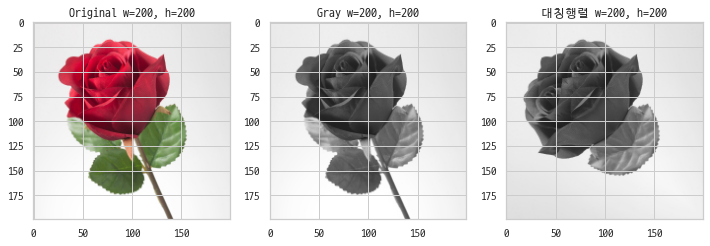

In [9]:
org_img1 = cv2.imread('flower.jpg', cv2.IMREAD_COLOR)
gray_img1 = cv2.cvtColor(org_img1, cv2.COLOR_BGR2GRAY)
TEST_IMG1 = make_symmetric(gray_img1)
height,width = TEST_IMG1.shape

fig, ax = plt.subplots(1, 3, figsize=(12,8))
plot_img(ax[0], f'Original w={width}, h={height}', org_img1)
plot_img(ax[1], f'Gray w={width}, h={height}', gray_img1)
plot_img(ax[2], f'대칭행렬 w={width}, h={height}', TEST_IMG1)


### 이미지 행렬을 고유값분해
- $ P, D, P^T$ 로 분해한다.

In [10]:
eigen_values, eigen_vector = np.linalg.eig(TEST_IMG1)

# 고유값을 정렬하고, 고유벡터도 정렬
def sort_by_eigen_values(eig_values, eig_vectors):
    # 역순, 절대값으로 정렬(절대값이 큰 것들이 영향도가 큼)
    indices = np.argsort(np.abs(eig_values))[::-1]
    eig_values = np.take_along_axis(eig_values, indices, axis=0)
    return eig_values, eig_vectors[:,indices]

EIGEN_VALUES, EIGEN_VECTORS = sort_by_eigen_values(eigen_values, eigen_vector)

print('EIGEN_VALUES.shape =', EIGEN_VALUES.shape )
print('EIGEN_VECTORS.shape =', EIGEN_VECTORS.shape )

EIGEN_VALUES.shape = (200,)
EIGEN_VECTORS.shape = (200, 200)


### 근사치 계산 로직(효율을 따져보자)
**계산의 효율성 문제**
- 예를 들어 이미지 너비가 200일때, N=2로 근사치 행렬을 만들려면?
- $ P D P^T $에서 $ D $의 대각원소는 200개이다.
- N=2로 근사치 행렬을 만든다는 것은 $ D $의 대각원소를 2개만 사용하겠다는 의미
- 그러면 $ D $의 세번째 이후의 대각원소를 0으로 두고 행렬을 곱해야겠다고 생각했다.
- 물론 이렇게 해도 되지만, 불필요한 행렬곱셈을 하게 된다.
    - 세번째 대각원소는 0이므로 곱하지 않아도 된다.
    - 따라서 198개의 원소가 의미없이 행렬곱셈에 투입되는 것이다.

**다음과 같이 로직을 정리하면 되겠다**

- N=1이면, 
    - $ D $는 1행만 사용한다.
    - 그래서 $ P D$ 행렬곱에서 $P$의 200행 1열만 의미가 있다. 다른 열은 곱해도 0이다.
    - 또 $D P^T$ 행렬곱에서 $P^T$의 1행 200열만 의미가 있다. 다른 행은 곱해도 0이다.
    - 따라서 $N=1$ 일때 행렬곱의 형태는  $ P_{200x1} \, D_{1x1} \, P^T_{1x200} $


- N=2이면, 
    - $ D $는 2행만 사용한다.
    - 그래서 $P D$ 행렬곱에서 $P$의 200행 2열만 의미가 있다. 다른 열은 곱해도 0이다.
    - 또 $D P^T$ 행렬곱에서 $P^T$도 2행 200열만 의미가 있다. 다른 행은 곱해도 0이다.
    - 따라서 $N=2$ 일때 행렬곱의 형태는
    $ P_{200x2} \, D_{2x2} \, P^T_{2x200} $

> 그리고 N의 최대값은 고유값의 개수이다.( $\lambda_n$ )

---

### 다양한 N값 별로 이미지의 근사치 행렬을 만들어서 출력

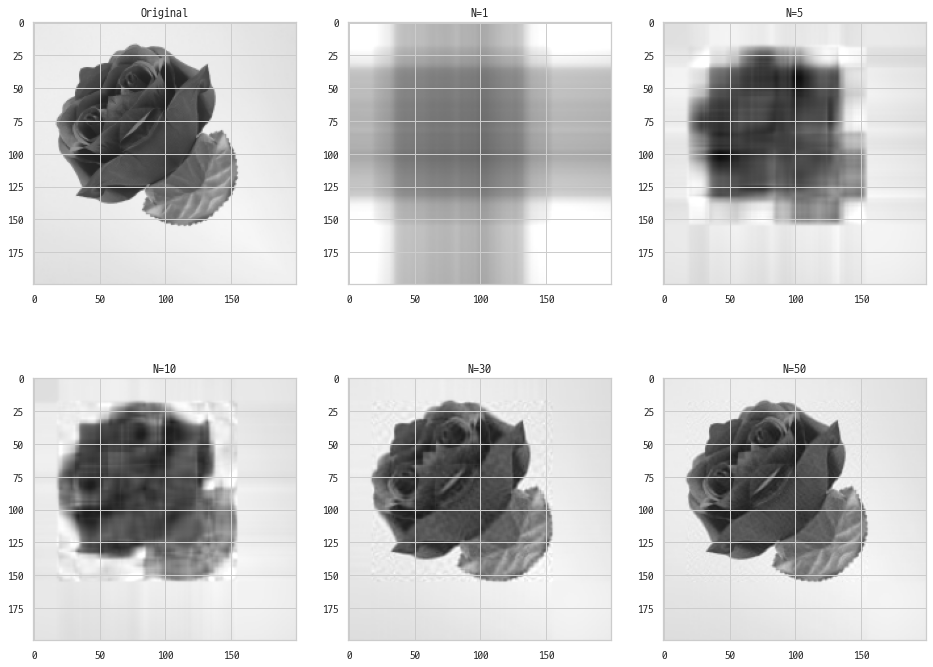

In [11]:
def approx(eig_values, eig_vectors, n):
    nn = np.min((n, len(eig_values)))
    D = np.diag(eig_values[:nn])
    P  = eig_vectors[:,:nn]    # n열만 계산에 포함
    PT = eig_vectors.T[:nn,:]  # n행만 계산에 포함
    res = P @ D @ PT
    # 근사치라서 255보다 조금 클 수도 있고
    # 0보다 조금 작을 수도 있다. 0~255사이로 보정
    return np.clip(res, 0, 255).astype('uint8')


# functools.partial로 함수를 단순화
approximate = functools.partial(approx, 
                                eig_values=EIGEN_VALUES, 
                                eig_vectors=EIGEN_VECTORS)

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(w=16, h=12)

plot_img(ax[0,0], 'Original', TEST_IMG1)
plot_img(ax[0,1], 'N=1', approximate(n=1))
plot_img(ax[0,2], 'N=5', approximate(n=5))
plot_img(ax[1,0], 'N=10', approximate(n=10))
plot_img(ax[1,1], 'N=30', approximate(n=30))
plot_img(ax[1,2], 'N=50', approximate(n=50))


끝